<a href="https://colab.research.google.com/github/wakame1367/Notebooks/blob/master/sentinel2_cloud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install -q s2cloudless rasterio pystac-client stackstac folium geojson shapely

In [38]:
# 東京
bbox = [139.75, 35.65, 139.85, 35.70]
# 対象期間
start_time = "2024-08-01T00:00:00Z"
end_time = "2024-08-10T23:59:59Z"
# 使用する STAC カタログ
catalog_url = "https://earth-search.aws.element84.com/v1"
# 対象コレクション
collection_id = "sentinel-2-l1c"

required_bands = ["coastal", "blue", "red", "rededge1", "nir", "nir08", "nir09", "cirrus", "swir16", "swir22"]
output_resolution = 60
output_crs = "EPSG:32654"

In [48]:
import os
import folium
from shapely.geometry import box
import geojson
import datetime
import stackstac
import pystac_client
import numpy as np
import rasterio
from s2cloudless import S2PixelCloudDetector
import matplotlib.pyplot as plt

In [49]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [6]:
catalog = pystac_client.Client.open(catalog_url)

In [7]:
catalog

<Client id=earth-search-aws>

In [8]:
search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=f"{start_time}/{end_time}",
    query={"eo:cloud_cover": {"lt": 10}},
    # sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    limit=10
)


In [9]:
items = search.item_collection()
print(f"Found {len(items)} items.")

Found 1 items.


In [22]:
center_lon = (bbox[0] + bbox[2]) / 2
center_lat = (bbox[1] + bbox[3]) / 2

In [32]:
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

In [33]:
bbox_polygon = box(bbox[0], bbox[1], bbox[2], bbox[3])
bbox_geojson = geojson.Feature(geometry=bbox_polygon, properties={"name": "Search BBOX"})

folium.GeoJson(
    bbox_geojson,
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.1
    },
    tooltip="Search BBOX"
).add_to(m)

In [34]:
item_geometry_geojson = items[0].geometry # これは既に GeoJSON 形式の辞書

# STAC アイテムのジオメトリを地図に追加
folium.GeoJson(
    item_geometry_geojson,
    style_function=lambda x: {
        'fillColor': 'red',
        'color': 'red',
        'weight': 3,
        'fillOpacity': 0.2
    },
    tooltip=f"AOI: {items[0].id}"
).add_to(m)

In [35]:
item_bbox = items[0].bbox # [min_lon, min_lat, max_lon, max_lat]
m.fit_bounds([[item_bbox[1], item_bbox[0]], [item_bbox[3], item_bbox[2]]])

In [36]:
folium.LayerControl().add_to(m)

In [37]:
m

In [10]:
# https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l1c/items/S2B_54SUE_20240804_0_L1C?.language=ja
items[0]

<Item id=S2B_54SUE_20240804_0_L1C>

In [17]:
int(output_crs.split(":")[1])

32654

In [40]:
data_cube = stackstac.stack(
        items[0],
        assets=required_bands,
        resolution=output_resolution,
        epsg=int(output_crs.split(":")[1]), # stackstac は EPSG コードの数値部分を期待
        bounds_latlon=bbox, # BBox を指定してクリップ
        dtype="float64", # L1C は通常 uint16
        rescale=False, # DN 値のまま読み込む
        # chunks={"x": 1024, "y": 1024, "band": -1} # メモリに合わせて調整
    )

In [41]:
data_cube = data_cube.sel(band=required_bands)

In [42]:
data_cube

<xarray.DataArray 'stackstac-424cfd0686e08a15c8ffa9aab3b13da9' (time: 1,
                                                                band: 10,
                                                                y: 95, x: 153)> Size: 1MB
dask.array<getitem, shape=(1, 10, 95, 153), dtype=float64, chunksize=(1, 1, 95, 153), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                              (time) datetime64[ns] 8B 2024-08-04T01:...
    id                                (time) <U24 96B 'S2B_54SUE_20240804_0_L1C'
  * band                              (band) <U8 320B 'coastal' ... 'swir22'
  * x                                 (x) float64 1kB 3.868e+05 ... 3.959e+05
  * y                                 (y) float64 760B 3.951e+06 ... 3.946e+06
    processing:software               object 8B {'sentinel2-to-stac': '0.1.1'}
    ...                                ...
    title                             (band) <U30 1kB 'Coastal aerosol (band ...
    gsd                               (band) int64 80B 60 10 10 20 ... 60 20 20
    common_name                       (band) <U7 280B 'coastal' ... 'swir22'
    center_wavelength                 (band) float64 80B 0.443 0.49 ... 2.19
    full_width_half_max               (band) float64 80B 0.027 0.098 ... 0.242
    epsg                              int64 8B 32654
Attributes:
    spec:        RasterSpec(epsg=32654, bounds=(386820, 3945720, 396000, 3951...
    crs:         epsg:32654
    transform:   | 60.00, 0.00, 386820.00|\n| 0.00,-60.00, 3951420.00|\n| 0.0...
    resolution:  60

In [43]:
toa_reflectance = (data_cube / 10000.0).astype(np.float32)

In [45]:
input_array_transposed = toa_reflectance.transpose('time', 'y', 'x', 'band')

In [46]:
input_array_transposed.sizes['time']

1

In [50]:
input_array = input_array_transposed.squeeze('time').values

In [51]:
input_array

array([[[0.2722, 0.2557, 0.2393, ..., 0.1011, 0.2575, 0.2346],
        [0.2716, 0.266 , 0.2505, ..., 0.101 , 0.2832, 0.2415],
        [0.2647, 0.21  , 0.1695, ..., 0.1009, 0.1905, 0.1596],
        ...,
        [0.2687, 0.295 , 0.2707, ..., 0.1007, 0.3013, 0.2646],
        [0.2747, 0.2296, 0.2278, ..., 0.1008, 0.2951, 0.2574],
        [0.281 , 0.249 , 0.2442, ..., 0.1008, 0.3137, 0.2731]],

       [[0.2709, 0.275 , 0.2478, ..., 0.1008, 0.2282, 0.188 ],
        [0.2674, 0.2361, 0.2123, ..., 0.1009, 0.237 , 0.2004],
        [0.2645, 0.2115, 0.1656, ..., 0.1008, 0.214 , 0.1638],
        ...,
        [0.2619, 0.2167, 0.1786, ..., 0.1009, 0.2584, 0.2082],
        [0.2712, 0.2631, 0.2528, ..., 0.1008, 0.2846, 0.2358],
        [0.2771, 0.2416, 0.2172, ..., 0.101 , 0.2687, 0.2226]],

       [[0.2773, 0.2407, 0.2182, ..., 0.1008, 0.237 , 0.1994],
        [0.2797, 0.2497, 0.2272, ..., 0.1009, 0.246 , 0.2047],
        [0.2748, 0.2378, 0.2181, ..., 0.101 , 0.2628, 0.2354],
        ...,
        [0.2

In [52]:
del data_cube
del toa_reflectance

In [53]:
cloud_detector = S2PixelCloudDetector(
        threshold=0.4,         # 雲と判断する確率の閾値
        average_over=1,        # 平均化フィルタのサイズ (ピクセル単位、0 or None で無効)
        dilation_size=1,       # 膨張処理のサイズ (ピクセル単位、0 or None で無効)
        all_bands=False
    )

In [54]:
cloud_probs = cloud_detector.get_cloud_probability_maps(input_array[np.newaxis, ...])

In [55]:
cloud_probs

array([[[0.9998307 , 0.99995273, 0.9999485 , ..., 0.99977624,
         0.9997045 , 0.9998944 ],
        [0.999863  , 0.99981934, 0.9998173 , ..., 0.9994368 ,
         0.99982417, 0.9998371 ],
        [0.9998778 , 0.9998217 , 0.99973893, ..., 0.99987066,
         0.9998441 , 0.99983186],
        ...,
        [0.9999143 , 0.99973243, 0.9997555 , ..., 0.9999664 ,
         0.99919486, 0.999219  ],
        [0.99993646, 0.9999085 , 0.99978995, ..., 0.99994653,
         0.99872816, 0.9997576 ],
        [0.99983853, 0.99989617, 0.9998856 , ..., 0.99991584,
         0.9969455 , 0.99982524]]], dtype=float32)

In [56]:
cloud_probs_map = cloud_probs[0]

In [57]:
print(f"Cloud probability map shape: {cloud_probs_map.shape}")

Cloud probability map shape: (95, 153)


In [58]:
cloud_mask = cloud_detector.get_mask_from_prob(cloud_probs)
cloud_mask_map = cloud_mask[0]
print(f"Cloud mask shape: {cloud_mask_map.shape}")

Cloud mask shape: (95, 153)


Displaying results...


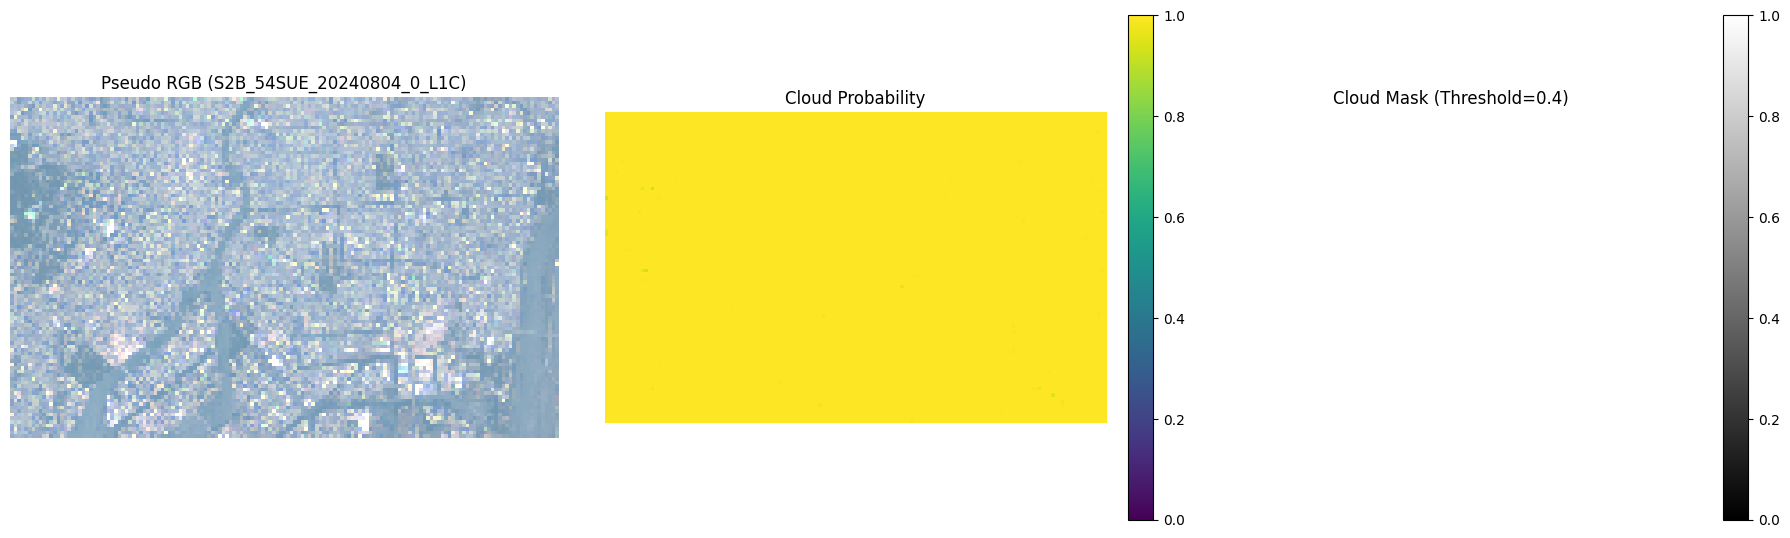

In [60]:
print("Displaying results...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RGB画像を簡易表示 (B04, B03, B02 を使うのが一般的だが、ここでは読み込んだバンドで代用)
# 反射率を [0, 0.3] 程度にクリップして表示を見やすくする
rgb_indices = [required_bands.index(b) for b in ["red", "blue", "coastal"] if b in required_bands] # R, G, B の順
if len(rgb_indices) == 3:
    rgb_image = np.clip(input_array[..., rgb_indices] * 3.0, 0, 1) # 明るさ調整
    axes[0].imshow(rgb_image)
    axes[0].set_title(f"Pseudo RGB ({items[0].id})")
else:
     axes[0].set_title("RGB bands not fully available")
axes[0].axis('off')


# 雲確率マップの表示
im1 = axes[1].imshow(cloud_probs_map, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("Cloud Probability")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 雲マスクの表示
im2 = axes[2].imshow(cloud_mask_map, cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Cloud Mask (Threshold={})".format(cloud_detector.threshold))
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
